In [36]:
import pandas as pd
import os
# add reading window size as part of code
wsize=80
%matplotlib inline
os.chdir('/Users/vinayswamy/NIH/eyesplice_predictor/')

In [2]:
col_names=['seqid', 'wstart','wend','ID']+list(range(80))
df=pd.read_csv('data/cleaned/HM7FMBBXX_16424750_S70_bp_features.tsv', sep='\t', header=None, names=col_names)

In [3]:
df.shape

(60246, 84)

In [4]:
df.head()

,seqid,wstart,wend,ID,0,1,2,3,4,5,...,70,71,72,73,74,75,76,77,78,79
0,chr1,17702,17782,ref_EL_172731,78,77,77,78,77,76,...,3,3,3,3,3,3,3,3,3,3
1,chr1,91589,91669,ref_EL_81828,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr1,135855,135935,ref_EL_89286,30,30,30,31,31,31,...,13,10,10,8,8,8,8,8,8,7
3,chr1,146469,146549,EL_1,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
4,chr1,195371,195451,ref_EL_167060,16,16,16,16,16,16,...,2,2,2,2,2,2,2,2,2,2


In [5]:
df['ID'].unique()

array(['ref_EL_172731', 'ref_EL_81828', 'ref_EL_89286', ...,
       'ref_EL_46095', 'ref_EL_90304', 'ref_EL_47363'], dtype=object)

In [6]:
#need to do 3 things - reverse the SL columns, remove low count exons, and make feature column
el=df[df['ID'].str.contains('EL')]
sl=df[df['ID'].str.contains('SL')]
rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
sl_rev=sl.loc[:,rev_idx]
sl_rev.columns=col_names
data=pd.concat([el, sl_rev]).assign(Y= lambda x: (~x['ID'].str.contains('ref')).astype(int))
data['Y'].value_counts()

0    30124
1    30122
Name: Y, dtype: int64

In [7]:
#remove low count exons
keep=data.loc[:,list(range(80))].sum(axis=1) >= 80
data_exp=data[keep]
data_exp['Y'].value_counts()

1    27499
0    24043
Name: Y, dtype: int64

In [8]:
#balance data for now
bal=data_exp['Y'].value_counts().min()
data_comp=pd.concat([data_exp[data_exp['Y']==1].sample(bal, random_state=420024),data_exp[data_exp['Y']==0].sample(bal, random_state=420024)])

In [9]:
print(data_comp.shape)
data_comp['Y'].value_counts()

(48086, 85)


1    24043
0    24043
Name: Y, dtype: int64

In [10]:
# above wrapped into a function for multiple sample use.
def pre_process(path, cut_off):
    col_names=['seqid', 'wstart','wend','ID']+list(range(80))
    df=pd.read_csv(path, sep='\t', header=None, names=col_names)
    el=df[df['ID'].str.contains('EL')]
    sl=df[df['ID'].str.contains('SL')]
    rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
    sl_rev=sl.loc[:,rev_idx]
    sl_rev.columns=col_names
    data=pd.concat([el, sl_rev]).assign(Y= lambda x: (~x['ID'].str.contains('ref')).astype(int))
    keep=data.loc[:,list(range(80))].sum(axis=1) >= cut_off
    data_exp=data[keep]
    bal=data_exp['Y'].value_counts().min()
    data_comp=pd.concat([data_exp[data_exp['Y']==1].sample(bal, random_state=420024), data_exp[data_exp['Y']== 0].sample(bal, random_state=420024)])
    return(data_comp)
    

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
x_cols=list(range(80))
X=data_comp.loc[:,x_cols]
Y=data_comp['Y']
pca=PCA(n_components=2)
pcmat=pca.fit_transform(X)
drX=pd.DataFrame(data=pcmat ,columns=['PC1', 'PC2']).assign(lab=Y)

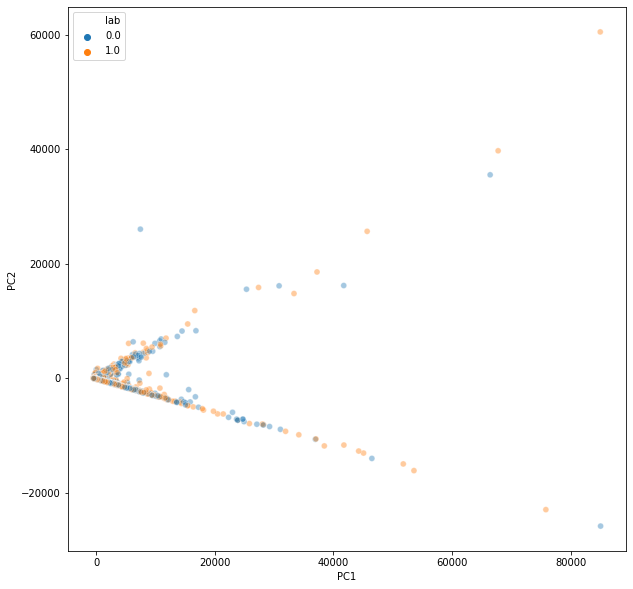

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=drX, x='PC1', y='PC2', hue='lab', alpha=.4)

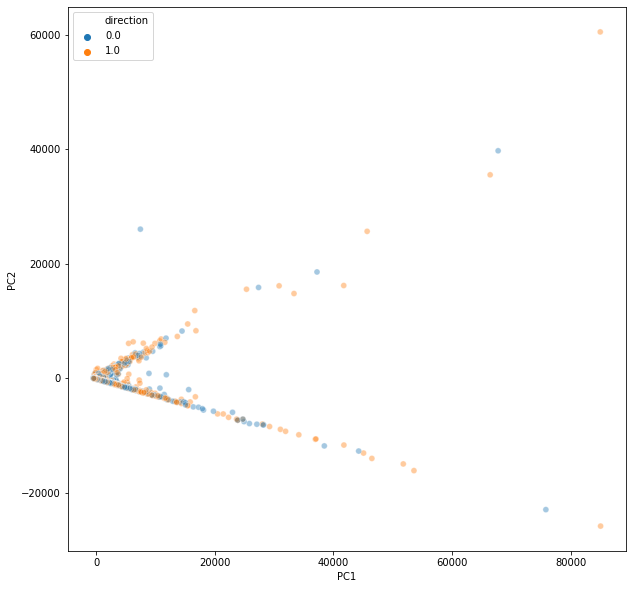

In [38]:
drX=drX.assign(direction=data_comp['ID'].str.contains('EL').astype(int))

plt.figure(figsize=(10,10))
sns.scatterplot(data=drX, x='PC1', y='PC2', hue='direction', alpha=.4)



In [35]:
pca.explained_variance_ratio_

array([0.84510364, 0.14251706])

PCA does not look that great,and I didn't boff the labels/ orientation, which leads me to ask, do we really need bp level info? may haps just the averages will work.

In [46]:
avg_df=(pd.DataFrame({'us_avg': data_comp.loc[:,list(range(40))].mean(axis=1),
                      'ds_avg': data_comp.loc[:,list(range(40,80))].mean(axis=1),
                      'us_var': data_comp.loc[:,list(range(40))].var(axis=1),
                      'ds_var': data_comp.loc[:,list(range(40,80))].var(axis=1),
                      'lab' : data_comp['Y']}))

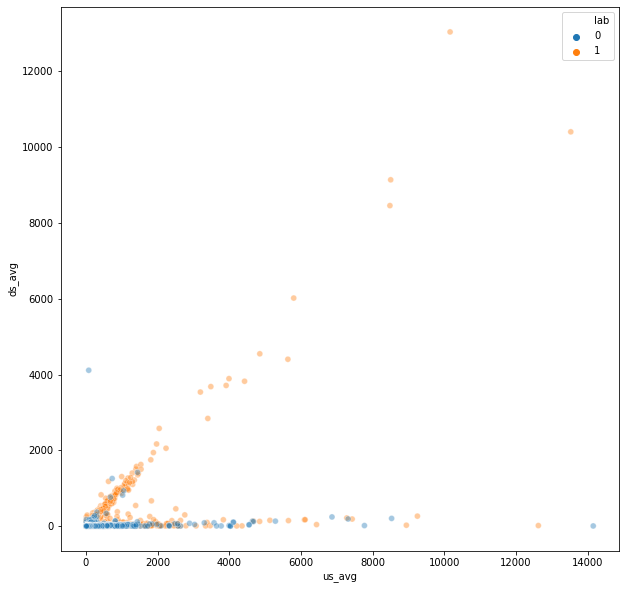

In [43]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=avg_df, x='us_avg', y='ds_avg', hue='lab', alpha=.4)